In [1]:
# Library imports
import tensorflow as tf
keras = tf.keras
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
# Add src directory to path for local imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils import gpu_grow_memory

In [3]:
gpu_grow_memory()

In [4]:
tf.keras.backend.clear_session()

In [5]:
inputs = keras.Input(shape=(784,), name='digits')
x1 = keras.layers.Dense(units=64, activation='relu', name='dense_1')(inputs)
x2 = keras.layers.Dense(units=64, activation='relu', name='dense_2')(x1)
outputs = keras.layers.Dense(units=10, activation='softmax', name='predictions')(x2)

model = keras.Model(inputs=inputs, outputs=outputs)

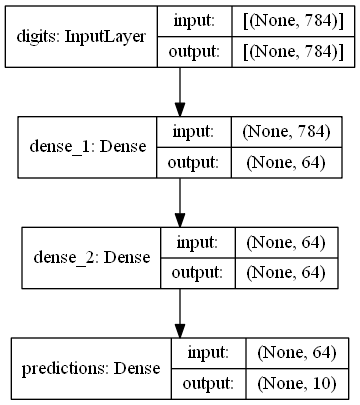

In [6]:
keras.utils.plot_model(model, show_shapes=True)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [8]:
(x_trn, y_trn), (x_tst, y_tst) = keras.datasets.mnist.load_data()

x_trn = x_trn.reshape(-1, 784).astype(np.float32) / 255.0
x_tst = x_tst.reshape(-1, 784).astype(np.float32) / 255.0

x_val = x_trn[-10000:]
y_val = y_trn[-10000:]

x_trn = x_trn[0:-10000]
y_trn = y_trn[0:-10000]

print(f'Size of data sets:')
print(f'x_trn: {len(x_trn)}')
print(f'x_val: {len(x_val)}')

Size of data sets:
x_trn: 50000
x_val: 10000


In [9]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [10]:
history = model.fit(x_trn, y_trn, batch_size=64, epochs=3, validation_data=(x_val, y_val))

W0618 13:09:01.455679 19256 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 3s 56us/sample - loss: 0.3432 - sparse_categorical_accuracy: 0.9009 - val_loss: 0.1697 - val_sparse_categorical_accuracy: 0.9524
Epoch 2/3
50000/50000 [==============================] - 2s 41us/sample - loss: 0.1603 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.1380 - val_sparse_categorical_accuracy: 0.9591
Epoch 3/3
50000/50000 [==============================] - 2s 43us/sample - loss: 0.1179 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.1100 - val_sparse_categorical_accuracy: 0.9688


In [11]:
history.history

{'loss': [0.3431918296146393, 0.16029592137813567, 0.11788016517877578],
 'sparse_categorical_accuracy': [0.90094, 0.95166, 0.96396],
 'val_loss': [0.1697282565832138, 0.13800958701074123, 0.10998089208602906],
 'val_sparse_categorical_accuracy': [0.9524, 0.9591, 0.9688]}

In [12]:
results = model.evaluate(x_tst, y_tst, batch_size=128)

10000/10000 [==============================] - 0s 14us/sample - loss: 0.1057 - sparse_categorical_accuracy: 0.9679


In [13]:
results

[0.1057437670454383, 0.9679]

In [14]:
pred = model.predict(x_tst)

In [15]:
pred[0]

array([2.7826511e-08, 1.3845968e-06, 3.4928056e-05, 9.6813026e-05,
       2.9448124e-11, 6.4331789e-07, 2.4216204e-11, 9.9986577e-01,
       3.5006889e-07, 1.8244140e-07], dtype=float32)

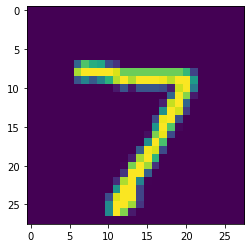

In [16]:
plt.imshow(x_tst[0].reshape(28,28))

In [17]:
def make_model_uncompiled():
    inputs = keras.Input(shape=(784,), name='digits')
    x1 = keras.layers.Dense(units=64, activation='relu', name='dense_1')(inputs)
    x2 = keras.layers.Dense(units=64, activation='relu', name='dense_2')(x1)
    outputs = keras.layers.Dense(units=10, activation='softmax', name='predictions')(x2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
def make_model_compiled():
    model = make_model_uncompiled()
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1.0E-3),
                  loss = keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

In [19]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name='categorical_true_positives', **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred)
        values = tf.equal(tf.cast(y_true, tf.int32), tf.cast(y_pred, tf.int32))
        values = tf.cast(values, tf.float32)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))
        
    def result(self):
        return self.true_positives
    
    def reset_states(self):
        self.true_positives.assign(0.0)

In [20]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1.0E-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy(), CategoricalTruePositives()])

In [21]:
model.fit(x_trn, y_trn, batch_size=64, epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 3s 50us/sample - loss: 0.0934 - sparse_categorical_accuracy: 0.9722 - categorical_true_positives: 8083.0000
Epoch 2/3
50000/50000 [==============================] - 2s 46us/sample - loss: 0.0765 - sparse_categorical_accuracy: 0.9766 - categorical_true_positives: 7860.0000
Epoch 3/3
50000/50000 [==============================] - 2s 45us/sample - loss: 0.0650 - sparse_categorical_accuracy: 0.9800 - categorical_true_positives: 8492.0000


In [22]:
class ActivityRegularizationLayer(keras.layers.Layer):
    def call(self, inputs):
        weight = 0.001
        self.add_loss(tf.reduce_sum(inputs) * weight)
        return inputs

    
def make_model2():
    inputs = keras.Input(shape=(784,), name='digits')
    x1 = keras.layers.Dense(units=64, activation='relu', name='dense_1')(inputs)
    x2 = ActivityRegularizationLayer(name='reg_2')(x1)
    x3 = keras.layers.Dense(units=64, activation='relu', name='dense_3')(x2)
    outputs = keras.layers.Dense(units=10, activation='softmax', name='predictions')(x3)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

model2 = make_model2()
model2.fit(x_trn, y_trn, batch_size=64, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 2s 41us/sample - loss: 0.7287 - sparse_categorical_accuracy: 0.8483


In [23]:
class MetricLoggingLayer(keras.layers.Layer):
    def call(self, inputs):
        self.add_metric(keras.backend.std(inputs), name='std_of_activation', aggregation='mean')
        return inputs
    
def make_model3():
    inputs = keras.Input(shape=(784,), name='digits')
    x1 = keras.layers.Dense(units=64, activation='relu', name='dense_1')(inputs)
    x2 = MetricLoggingLayer(name='log_2')(x1)
    x3 = keras.layers.Dense(units=64, activation='relu', name='dense_3')(x2)
    outputs = keras.layers.Dense(units=10, activation='softmax', name='predictions')(x3)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

model3 = make_model3()
model3.fit(x_trn, y_trn, batch_size=64, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 2s 44us/sample - loss: 0.3459 - sparse_categorical_accuracy: 0.9014 - std_of_activation: 0.9258


In [24]:
def make_model4():
    inputs = keras.Input(shape=(784,), name='digits')
    x1 = keras.layers.Dense(units=64, activation='relu', name='dense_1')(inputs)
    x2 = keras.layers.Dense(units=64, activation='relu', name='dense_3')(x1)
    outputs = keras.layers.Dense(units=10, activation='softmax', name='predictions')(x2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.add_loss(tf.reduce_sum(x1) * 0.001)
    model.add_metric(keras.backend.std(x1), name='std_of_activation', aggregation='mean')

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

model4 = make_model4()
model4.fit(x_trn, y_trn, batch_size=64, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 3s 56us/sample - loss: 0.7048 - sparse_categorical_accuracy: 0.8637 - std_of_activation: 0.2335


In [25]:
model5 = make_model_compiled()
model5.fit(x_trn, y_trn, batch_size=64, epochs=3, validation_split=0.20)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 2s 48us/sample - loss: 0.3777 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.2222 - val_sparse_categorical_accuracy: 0.9333
Epoch 2/3
40000/40000 [==============================] - 2s 45us/sample - loss: 0.1713 - sparse_categorical_accuracy: 0.9485 - val_loss: 0.1711 - val_sparse_categorical_accuracy: 0.9495
Epoch 3/3
40000/40000 [==============================] - 2s 44us/sample - loss: 0.1259 - sparse_categorical_accuracy: 0.9623 - val_loss: 0.1608 - val_sparse_categorical_accuracy: 0.9522


In [26]:
dataset_trn = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
dataset_trn = dataset_trn.shuffle(buffer_size=1024).batch(64)

dataset_tst = tf.data.Dataset.from_tensor_slices((x_tst, y_tst)).batch(64)

In [27]:
model = make_model_compiled()
history = model.fit(dataset_trn, epochs=3)

Epoch 1/3
782/782 [==============================] - 3s 4ms/step - loss: 0.3400 - sparse_categorical_accuracy: 0.9035
Epoch 2/3
782/782 [==============================] - 3s 3ms/step - loss: 0.1618 - sparse_categorical_accuracy: 0.9530
Epoch 3/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9655


In [28]:
model.evaluate(dataset_tst)

157/157 [==============================] - 0s 3ms/step - loss: 0.1358 - sparse_categorical_accuracy: 0.9598


[0.13577607966022223, 0.9598]

In [29]:
model.fit(dataset_trn.take(100), epochs=3)

Epoch 1/3
100/100 [==============================] - 0s 3ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9741
Epoch 2/3
100/100 [==============================] - 0s 3ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9817
Epoch 3/3
100/100 [==============================] - 0s 3ms/step - loss: 0.0492 - sparse_categorical_accuracy: 0.9877


In [30]:
dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(64)
history = model.fit(dataset_trn, epochs=3, validation_data=dataset_val)

Epoch 1/3
782/782 [==============================] - 3s 4ms/step - loss: 0.0929 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.1162 - val_sparse_categorical_accuracy: 0.9676
Epoch 2/3
782/782 [==============================] - 3s 4ms/step - loss: 0.0775 - sparse_categorical_accuracy: 0.9782 - val_loss: 0.1119 - val_sparse_categorical_accuracy: 0.9708
Epoch 3/3
782/782 [==============================] - 3s 4ms/step - loss: 0.0665 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.1116 - val_sparse_categorical_accuracy: 0.9719


In [31]:
history = model.fit(dataset_trn, epochs=3, validation_data=dataset_val, validation_steps=10)

Epoch 1/3
782/782 [==============================] - 3s 4ms/step - loss: 0.0583 - sparse_categorical_accuracy: 0.9844 - val_loss: 0.1658 - val_sparse_categorical_accuracy: 0.9625
Epoch 2/3
782/782 [==============================] - 3s 3ms/step - loss: 0.0511 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.1682 - val_sparse_categorical_accuracy: 0.9578
Epoch 3/3
782/782 [==============================] - 3s 4ms/step - loss: 0.0446 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.1781 - val_sparse_categorical_accuracy: 0.9531


In [32]:
class_weight = {i: 1.0 for i in range(10)}
class_weight[5] = 2.0

history = model.fit(x_trn, y_trn, class_weight=class_weight, batch_size=64, epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 3s 53us/sample - loss: 0.0514 - sparse_categorical_accuracy: 0.9858
Epoch 2/3
50000/50000 [==============================] - 2s 50us/sample - loss: 0.0441 - sparse_categorical_accuracy: 0.9877
Epoch 3/3
50000/50000 [==============================] - 2s 49us/sample - loss: 0.0385 - sparse_categorical_accuracy: 0.9894


In [33]:
sample_weight = np.ones(shape=y_trn.shape)
sample_weight[y_trn==5] = 2.0

history = model.fit(x_trn, y_trn, sample_weight=sample_weight, batch_size=64, epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 2s 49us/sample - loss: 0.0333 - sparse_categorical_accuracy: 0.9905
Epoch 2/3
50000/50000 [==============================] - 3s 51us/sample - loss: 0.0305 - sparse_categorical_accuracy: 0.9912
Epoch 3/3
50000/50000 [==============================] - 2s 49us/sample - loss: 0.0276 - sparse_categorical_accuracy: 0.9925


In [34]:
dataset_trn = tf.data.Dataset.from_tensor_slices((x_trn, y_trn, sample_weight))
dataset_trn = dataset_trn.shuffle(buffer_size=1024).batch(64)

model.fit(dataset_trn, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9936


In [35]:
input_image = keras.Input(shape=(32, 32, 3,), name='input_image')
input_ts = keras.Input(shape=(None, 10,), name='input_ts')
inputs = [input_image, input_ts]

x1a = keras.layers.Conv2D(filters=3, kernel_size=(3,3,), name='conv_1a')(input_image)
x1b = keras.layers.GlobalMaxPooling2D(name='pool_1b')(x1a)

x2a = keras.layers.Conv1D(filters=3, kernel_size=(3,), name='conv_2a')(input_ts)
x2b = keras.layers.GlobalMaxPooling1D(name='pool_2b')(x2a)

x3 = keras.layers.concatenate(inputs=[x1b, x2b], name='concat_3')

output_score = keras.layers.Dense(units=1, name='output_score')(x3)
output_class = keras.layers.Dense(units=5, activation='softmax', name='output_class')(x3)
outputs= [output_score, output_class]

model = keras.Model(inputs=inputs, outputs=outputs)

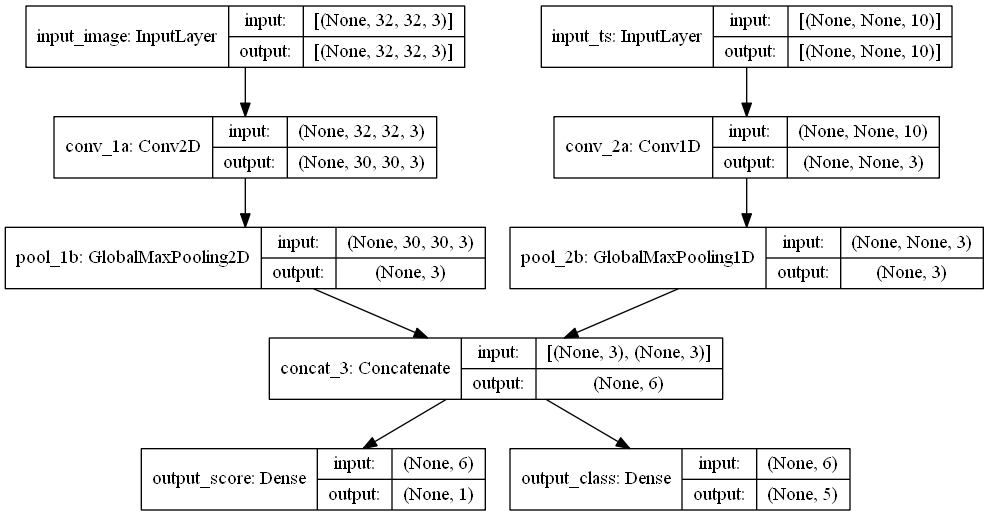

In [36]:
keras.utils.plot_model(model, show_shapes=True)

In [37]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_ts (InputLayer)           [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
conv_1a (Conv2D)                (None, 30, 30, 3)    84          input_image[0][0]                
__________________________________________________________________________________________________
conv_2a (Conv1D)                (None, None, 3)      93          input_ts[0][0]                   
____________________________________________________________________________________________

In [46]:
loss = {'output_score': keras.losses.MeanSquaredError(),
        'output_class': keras.losses.CategoricalCrossentropy()}

metrics = {'output_score': [keras.metrics.MeanAbsolutePercentageError(),
                            keras.metrics.MeanAbsoluteError()],
           'output_class': [keras.metrics.CategoricalAccuracy()]}

loss_weights = {'output_score': 2.0,
               'output_class': 1.0}

# model1 = tf.keras.models.clone_model(model)
# model2 = tf.keras.models.clone_model(model)

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1.0E-3),
              loss=loss,
              metrics=metrics)

In [47]:
data_image = np.random.random_sample(size=(100, 32, 32, 3,))
data_ts = np.random.random_sample(size=(100,20,10,))
data_list = [data_image, data_ts]
data_dict = {'input_image': data_image,
             'input_ts': data_ts}

targets_score = np.random.random_sample(size=(100,1,))
targets_class = np.random.random_sample(size=(100,5,))
targets_list = [targets_score, targets_class]
targets_dict = {'output_score': targets_score,
                'output_class': targets_class}

In [49]:
hiostry = model.fit(x=data_dict, y=targets_dict, batch_size=32, epochs=3)

Train on 100 samples
Epoch 1/3
100/100 [==============================] - 0s 250us/sample - loss: 7.6954 - output_score_loss: 1.9342 - output_class_loss: 5.6072 - output_score_mean_absolute_percentage_error: 808.2719 - output_score_mean_absolute_error: 1.3890 - output_class_categorical_accuracy: 0.1800
Epoch 2/3
100/100 [==============================] - 0s 250us/sample - loss: 7.0525 - output_score_loss: 1.4138 - output_class_loss: 5.4300 - output_score_mean_absolute_percentage_error: 653.7198 - output_score_mean_absolute_error: 1.1768 - output_class_categorical_accuracy: 0.1800
Epoch 3/3
100/100 [==============================] - 0s 230us/sample - loss: 6.5502 - output_score_loss: 1.0135 - output_class_loss: 5.5141 - output_score_mean_absolute_percentage_error: 523.9642 - output_score_mean_absolute_error: 0.9849 - output_class_categorical_accuracy: 0.1800


In [52]:
dataset_trn = tf.data.Dataset.from_tensor_slices((data_dict, targets_dict))
dataset_trn = dataset_trn.shuffle(buffer_size=1024).batch(64)

In [53]:
history = model.fit(dataset_trn, epochs=3)

Epoch 1/3
2/2 [==============================] - 0s 172ms/step - loss: 6.2289 - output_score_loss: 0.7892 - output_class_loss: 5.4424 - output_score_mean_absolute_percentage_error: 437.6691 - output_score_mean_absolute_error: 0.8422 - output_class_categorical_accuracy: 0.1800
Epoch 2/3
2/2 [==============================] - 0s 8ms/step - loss: 6.0610 - output_score_loss: 0.6633 - output_class_loss: 5.4016 - output_score_mean_absolute_percentage_error: 381.5578 - output_score_mean_absolute_error: 0.7616 - output_class_categorical_accuracy: 0.1800
Epoch 3/3
2/2 [==============================] - 0s 8ms/step - loss: 5.9129 - output_score_loss: 0.5567 - output_class_loss: 5.3611 - output_score_mean_absolute_percentage_error: 329.5727 - output_score_mean_absolute_error: 0.6872 - output_class_categorical_accuracy: 0.1800


In [54]:
history.history

{'loss': [6.223586540222168, 6.053357086181641, 5.903147754669189],
 'output_score_loss': [0.7891806, 0.6632602, 0.5567042],
 'output_class_loss': [5.4423823, 5.4015956, 5.36114],
 'output_score_mean_absolute_percentage_error': [437.66907,
  381.55777,
  329.5727],
 'output_score_mean_absolute_error': [0.8422146, 0.76160836, 0.687199],
 'output_class_categorical_accuracy': [0.18, 0.18, 0.18]}

In [57]:
num_samples=120
data_image = np.random.random_sample(size=(num_samples, 32, 32, 3,))
data_ts = np.random.random_sample(size=(num_samples,20,10,))

targets_score = np.random.random_sample(size=(num_samples,1,))
targets_class = np.random.random_sample(size=(num_samples,5,))

def trn_tst(x):
    return x[:100], x[100:]

data_image_trn, data_image_val = trn_tst(data_image)
data_ts_trn, data_ts_val = trn_tst(data_ts)
targets_score_trn, targets_score_val = trn_tst(targets_score)
targets_class_trn, targets_class_val = trn_tst(targets_class)

data_dict_trn = {'input_image': data_image_trn,
                 'input_ts': data_ts_trn}

data_dict_val = {'input_image': data_image_val,
                 'input_ts': data_ts_val}

targets_dict_trn = {'output_score': targets_score_trn,
                    'output_class': targets_class_trn}

targets_dict_val = {'output_score': targets_score_val,
                    'output_class': targets_class_val}

In [60]:
dataset_trn = tf.data.Dataset.from_tensor_slices((data_dict_trn, targets_dict_trn))
dataset_trn = dataset_trn.shuffle(buffer_size=1024).batch(64)

dataset_val = tf.data.Dataset.from_tensor_slices((data_dict_val, targets_dict_val))
dataset_val = dataset_val.batch(64)

In [61]:
model.fit(dataset_trn, epochs=3, validation_data=dataset_val)

Epoch 1/3
2/2 [==============================] - 0s 117ms/step - loss: 5.2839 - output_score_loss: 0.3632 - output_class_loss: 4.9142 - output_score_mean_absolute_percentage_error: 232.5391 - output_score_mean_absolute_error: 0.4977 - output_class_categorical_accuracy: 0.2300 - val_loss: 5.3475 - val_output_score_loss: 0.2726 - val_output_class_loss: 5.0749 - val_output_score_mean_absolute_percentage_error: 130.2594 - val_output_score_mean_absolute_error: 0.4395 - val_output_class_categorical_accuracy: 0.2500
Epoch 2/3
2/2 [==============================] - 0s 13ms/step - loss: 5.1980 - output_score_loss: 0.3122 - output_class_loss: 4.8798 - output_score_mean_absolute_percentage_error: 207.6250 - output_score_mean_absolute_error: 0.4554 - output_class_categorical_accuracy: 0.2300 - val_loss: 5.2675 - val_output_score_loss: 0.2321 - val_output_class_loss: 5.0354 - val_output_score_mean_absolute_percentage_error: 137.3746 - val_output_score_mean_absolute_error: 0.4021 - val_output_class_

In [65]:
model = make_model_compiled()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)]

model.fit(x_trn, y_trn, epochs=20, batch_size=64, callbacks=callbacks, validation_split=0.20)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 2s 49us/sample - loss: 0.3800 - sparse_categorical_accuracy: 0.8918 - val_loss: 0.2247 - val_sparse_categorical_accuracy: 0.9329
Epoch 2/20
40000/40000 [==============================] - 2s 43us/sample - loss: 0.1750 - sparse_categorical_accuracy: 0.9482 - val_loss: 0.1892 - val_sparse_categorical_accuracy: 0.9423
Epoch 3/20
40000/40000 [==============================] - 2s 43us/sample - loss: 0.1281 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.1577 - val_sparse_categorical_accuracy: 0.9544
Epoch 4/20
40000/40000 [==============================] - 2s 44us/sample - loss: 0.1006 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.1427 - val_sparse_categorical_accuracy: 0.9585
Epoch 5/20
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0828 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.1275 - val_sparse_categorical_accuracy: 0.9619
Epoch 6/20
4000

In [67]:
model = make_model_compiled()

callbacks = [keras.callbacks.ModelCheckpoint(filepath='./checkpoints/mymodel_{epoch}.h5', save_best_only=True, 
                                             monitor='val_loss', verbise=1)]

model.fit(x_trn, y_trn, epochs=3, batch_size=64, callbacks=callbacks, validation_split=0.20)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 2s 52us/sample - loss: 0.3790 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.2297 - val_sparse_categorical_accuracy: 0.9316
Epoch 2/3
40000/40000 [==============================] - 2s 44us/sample - loss: 0.1669 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.1998 - val_sparse_categorical_accuracy: 0.9396
Epoch 3/3
40000/40000 [==============================] - 2s 44us/sample - loss: 0.1216 - sparse_categorical_accuracy: 0.9628 - val_loss: 0.1491 - val_sparse_categorical_accuracy: 0.9569


In [70]:
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir='./logs')
model.fit(x_trn, y_trn, epochs=10, callbacks=[tensorboard_cbk])

Train on 50000 samples
Epoch 1/10
   32/50000 [..............................] - ETA: 2:26 - loss: 0.0661 - sparse_categorical_accuracy: 0.9688

NotFoundError: Failed to create a directory: ./logs\train\plugins\profile\2019-06-18_15-13-45; No such file or directory

<BatchDataset shapes: ({input_image: (None, 32, 32, 3), input_ts: (None, 20, 10)}, {output_score: (None, 1), output_class: (None, 5)}), types: ({input_image: tf.float64, input_ts: tf.float64}, {output_score: tf.float64, output_class: tf.float64})>